<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импортируем-необходимые-библиотеки" data-toc-modified-id="Импортируем-необходимые-библиотеки-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импортируем необходимые библиотеки</a></span></li><li><span><a href="#Посмортим-общую-информацию-о-датасете:" data-toc-modified-id="Посмортим-общую-информацию-о-датасете:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Посмортим общую информацию о датасете:</a></span></li><li><span><a href="#Пропуски:" data-toc-modified-id="Пропуски:-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Пропуски:</a></span></li><li><span><a href="#Посмотрим-на-дисбаланс-классов" data-toc-modified-id="Посмотрим-на-дисбаланс-классов-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Посмотрим на дисбаланс классов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия-(с-гридсёрчем)" data-toc-modified-id="Логистическая-регрессия-(с-гридсёрчем)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия (с гридсёрчем)</a></span></li><li><span><a href="#CatBoost-(обучал-на-GPU)" data-toc-modified-id="CatBoost-(обучал-на-GPU)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost (обучал на GPU)</a></span></li><li><span><a href="#Dummyclassifier" data-toc-modified-id="Dummyclassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Dummyclassifier</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с toxic-bert

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

### Цель

Необходимо обучить модель классифицировать комментарии на позитивные и негативные.

### Описание данных

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импортируем необходимые библиотеки

In [28]:
import gc
from string import punctuation

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from catboost import CatBoostClassifier
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import notebook
from transformers import AutoModel, AutoTokenizer

### Считываем данные

In [29]:
try:
    data = pd.read_csv('C:/Users/dmitr/Jupiter_Notebook/datasets/Module_3/toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

### Посмортим общую информацию о датасете:

In [30]:
display(data.info())
display(data.sample(5, random_state=12345))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
109583,Expert Categorizers \n\nWhy is there no menti...,0
105077,"""\n\n Noise \n\nfart* talk. """,1
82244,"An indefinite block is appropriate, even for a...",0
18740,I don't understand why we have a screenshot of...,0
128310,"Hello! Some of the people, places or things yo...",0


### Пропуски:

In [31]:
print(data[data['toxic'].isna()])
print(data[data['text'].isna()])

Empty DataFrame
Columns: [text, toxic]
Index: []
Empty DataFrame
Columns: [text, toxic]
Index: []


Пропусков в датасете нет.

### Посмотрим на дисбаланс классов

In [32]:
print(data['toxic'].value_counts())

0    143106
1     16186
Name: toxic, dtype: int64


Index(['positive', 'toxic'], dtype='object', name='toxic')
Index(['Ratio'], dtype='object')


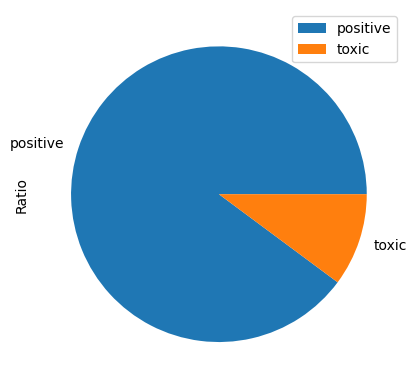

In [33]:
grouped_data = data.groupby('toxic').count()
grouped_data.rename(index={0: 'positive', 1: 'toxic'}, columns={'text': 'Ratio'}, inplace=True)
grouped_data.plot(kind='pie', y='Ratio', legend=True);

Можно заметить, что токсичных комментариев примерно в 9 раз меньше, чем не токсичных, что говорит о сильном дисбалансе классов

### Построю бар и облако слов для отображения наиболее распространенных слов в твитах:

Предварительно удалю стоп слова и знаки препинания

In [34]:
nltk.download('stopwords')
nltk.download('punkt')
english_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
print(english_stopwords)

{'doing', 'ma', 'won', 'mustn', "it's", 'few', 'o', 'during', 'can', 'our', 'each', 'above', 'up', "shouldn't", 'why', 'had', 'the', 'against', 'ain', 'having', 'a', 'who', 'ourselves', 'been', 'now', 'that', 'i', 've', 'himself', 'is', 'has', "hasn't", 'him', 'they', 'are', 'after', "didn't", 'wouldn', 'here', 'some', 'myself', 'out', 'with', 'too', 'once', 'shouldn', "that'll", 'most', 'being', 'at', 'off', 'isn', 'couldn', 'same', 'be', 'hers', 'own', 'their', "you're", 'wasn', 'doesn', "wasn't", "won't", "mightn't", 'further', 'on', 'under', 't', 'does', 'do', 'as', 'weren', 'about', 'm', 'did', 'didn', 'yourselves', 'so', 'below', 'needn', 'he', 'my', 'ours', 'such', "couldn't", "shan't", 'will', 'hasn', 'while', "wouldn't", 'was', 'there', "weren't", 'mightn', 'from', 'should', 'and', 'were', 'until', 'through', 'yourself', 'theirs', 'because', 'of', 'more', 'or', 'you', "needn't", 'nor', 'in', 'if', "aren't", "doesn't", 'again', 'her', 'd', 'shan', "you've", 'then', "hadn't", 't

In [36]:
without_punctuation = [''.join([char for char in value if char not in punctuation]) for value in data['text'].values]

In [37]:
without_stopwords = [' '.join([word for word in tweet.lower().split() if word not in english_stopwords]) for tweet in
                     without_punctuation]
print(len(without_stopwords))

159292


In [38]:
all_cleared_tweets = ' '.join(without_stopwords)
print(all_cleared_tweets[:1000])

explanation edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired now892053827 daww matches background colour im seemingly stuck thanks talk 2151 january 11 2016 utc hey man im really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info cant make real suggestions improvement wondered section statistics later subsection types accidents think references may need tidying exact format ie date format etc later noone else first preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns listed relevant form eg wikipediagoodarticlenominationstransport sir hero chance remember page thats congratulations well use tools well · talk cocksucker piss around work vandalism matt shirvington article reverted please dont banned sorry word nonsense offensive any

In [39]:
freq_dist = FreqDist(word.lower() for word in word_tokenize(all_cleared_tweets))

In [40]:
print(freq_dist.most_common(15))

[('article', 55306), ('page', 45468), ('wikipedia', 35503), ('talk', 30891), ('please', 29555), ('would', 29154), ('one', 27999), ('like', 27633), ('dont', 25665), ('see', 21434), ('also', 20480), ('think', 19988), ('im', 19210), ('know', 18940), ('people', 17634)]


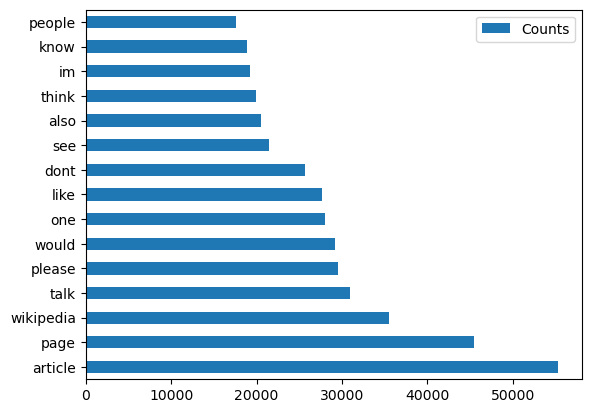

In [41]:
common_dict = dict(freq_dist.most_common(15))
most_common_words_data = pd.DataFrame(data=common_dict.values(), columns=['Counts'], index=list(common_dict.keys()))
most_common_words_data.plot(kind='barh');

In [42]:
word_cloud = WordCloud().generate(all_cleared_tweets)

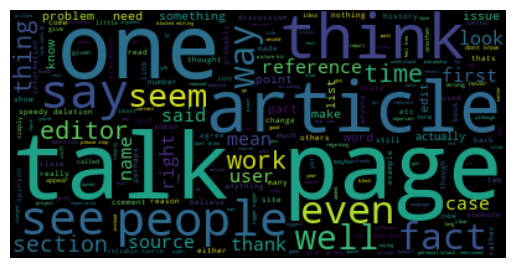

In [43]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Обучение

Загружаю предобученную модель toxic-bert, получать эмбеддинги и обучать модель буду на GPU

In [44]:
tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained('unitary/toxic-bert').to(device)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
example_data = data.copy()

Получаю вектор токенов (лемматизация не нужна, модель предобучена и понимает формы различных слов)

In [46]:
tokenized = example_data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


Применяю метод "padding"

In [47]:
max_length = -1
for i in tokenized.values:
    if len(i) > max_length:
        max_length = len(i)
print(max_length)
padded = np.array([vector + [0] * (max_length - len(vector)) for vector in tokenized.values])

4950


In [48]:
print(padded.shape)

(159292, 4950)


Обращаю внимание модели, что нули не несут никакой значимой информации

In [49]:
attention_mask = np.where(padded != 0, 1, 0)

Сборщиком мусора удаляю все ненужные переменные, также очищаю вычисления, сохраненные в графическом процессоре

In [50]:
torch.cuda.empty_cache()
gc.collect()

0

Создаю эмбеддинги

In [51]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range((padded.shape[0] - 1) // batch_size + 1)):
    batch_embeddings_j = []
    for j in range((padded.shape[1] - 1) // 512 + 1):
        batch = torch.tensor(padded[batch_size * i:batch_size * (i + 1), j * 512:(j + 1) * 512], device=device)
        attention_mask_batch = torch.tensor(attention_mask[batch_size * i:batch_size * (i + 1), j * 512:(j + 1) * 512],
                                            device=device)
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        batch_embeddings_j.append(batch_embeddings[0][:, 0, :].cpu().numpy())
    embeddings.append(batch_embeddings_j)
    torch.cuda.empty_cache()
    gc.collect()

  0%|          | 0/1593 [00:00<?, ?it/s]

In [52]:
torch.cuda.empty_cache()
gc.collect()

18

In [53]:
print(len(embeddings))
print(len(embeddings[0][0]))
print(embeddings[0][0])

1593
100
[[-0.5585107  -1.0476651   0.7199489  ... -0.71159047  0.5249052
   0.1127703 ]
 [-0.59337103 -0.9981305   0.6239386  ... -0.69221896  0.4633578
   0.10821168]
 [-0.61220884 -0.8657579   0.7485891  ... -0.6126195   0.5090271
   0.13732637]
 ...
 [-0.76659364 -0.995222    0.5457629  ... -0.8230476   0.39490667
   0.22017561]
 [-0.57066506 -0.99152106  0.60527635 ... -0.6693468   0.39768806
   0.04599227]
 [-0.35925698 -0.8368207   0.7603383  ... -0.67306453  0.45177606
   0.1696786 ]]


In [54]:
features = np.concatenate([embeddings[i][0] for i in range(len(embeddings))])
print(features.shape)

(159292, 768)


Делю данные на тренировочную и тестовую выборки

In [55]:
features_train, features_test, target_train, target_test = train_test_split(features, example_data['toxic'],
                                                                            test_size=0.2,
                                                                            stratify=example_data['toxic'])
print(features_train.shape)
print(features_test.shape)

(127433, 768)
(31859, 768)


### Логистическая регрессия (с гридсёрчем)

In [56]:
model_lr = LogisticRegression(random_state=12345, class_weight='balanced')
gs_lr = GridSearchCV(estimator=model_lr, param_grid={'C': np.arange(0.1, 10.2, 1.0)}, cv=5, scoring='f1', n_jobs=-1)

In [57]:
gs_lr.fit(features_train, target_train)

C:\Users\dmitr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345),
             n_jobs=-1,
             param_grid={'C': array([ 0.1,  1.1,  2.1,  3.1,  4.1,  5.1,  6.1,  7.1,  8.1,  9.1, 10.1])},
             scoring='f1')

In [58]:
print(gs_lr.best_params_)
print(f'F1_score (on training sample) for LogisticRegression: {gs_lr.best_score_}')
print(f'Accuracy (on training sample) for LogisticRegression: {accuracy_score(target_train,gs_lr.predict(features_train))}')

{'C': 2.1}
F1_score (on training sample) for LogisticRegression: 0.925605459654965
Accuracy (on training sample) for LogisticRegression: 0.9846821466966955


### CatBoost (обучал на GPU)

In [60]:
torch.cuda.empty_cache()
gc.collect()

630

In [61]:
model_catboost = CatBoostClassifier(eval_metric='F1', max_depth=4, iterations=1000,
                                    task_type='GPU' if torch.cuda.is_available() else 'CPU', class_weights={0:1,1:len(example_data[example_data['toxic'] == 0])/len(example_data[example_data['toxic'] == 1])})

In [62]:
model_catboost.fit(features_train, target_train);

Learning rate set to 0.025822
0:	learn: 0.9809752	total: 76.2ms	remaining: 1m 16s
1:	learn: 0.9816940	total: 135ms	remaining: 1m 7s
2:	learn: 0.9820694	total: 186ms	remaining: 1m 1s
3:	learn: 0.9822820	total: 247ms	remaining: 1m 1s
4:	learn: 0.9823772	total: 271ms	remaining: 54s
5:	learn: 0.9824954	total: 287ms	remaining: 47.6s
6:	learn: 0.9824642	total: 303ms	remaining: 43s
7:	learn: 0.9827267	total: 318ms	remaining: 39.4s
8:	learn: 0.9830991	total: 333ms	remaining: 36.6s
9:	learn: 0.9832932	total: 350ms	remaining: 34.6s
10:	learn: 0.9832431	total: 365ms	remaining: 32.8s
11:	learn: 0.9832908	total: 380ms	remaining: 31.3s
12:	learn: 0.9833286	total: 395ms	remaining: 30s
13:	learn: 0.9831564	total: 410ms	remaining: 28.9s
14:	learn: 0.9832682	total: 425ms	remaining: 27.9s
15:	learn: 0.9832688	total: 441ms	remaining: 27.1s
16:	learn: 0.9833024	total: 460ms	remaining: 26.6s
17:	learn: 0.9834374	total: 475ms	remaining: 25.9s
18:	learn: 0.9835937	total: 487ms	remaining: 25.2s
19:	learn: 0.98

In [63]:
print(f'F1_score  (on training sample) for CatBoostClassifier: {model_catboost.best_score_["learn"]["F1"]:.5f}')
print(f'Accuracy (on training sample) for CatBoostClassifier: {accuracy_score(target_train, model_catboost.predict(features_train))}')

F1_score  (on training sample) for CatBoostClassifier: 0.99177
Accuracy (on training sample) for CatBoostClassifier: 0.9876013277565466


### Dummyclassifier

In [64]:
dummy_classifier = DummyClassifier(strategy='constant', random_state=12345, constant=1)
dummy_classifier.fit(features_train, target_train)
print(f'F1_score (on training sample) for Dummyclassifier: {f1_score(target_train, dummy_classifier.predict(features_train))}')
print(f'Accuracy (on training sample) for Dummyclassifier: {accuracy_score(target_train, dummy_classifier.predict(features_train))}')

F1_score (on training sample) for Dummyclassifier: 0.18448234104087421
Accuracy (on training sample) for Dummyclassifier: 0.10161418156992302


Точность и f1-мера оставляют желать лучшего...

## Тестирование

Лучше всего себя показала модель СatBoost

In [65]:
best_model = model_catboost
print(f'F1_score (on testing sample) for best_model: {f1_score(target_test, best_model.predict(features_test))}')

F1_score (on testing sample) for best_model: 0.9232340922358436


## Вывод

В данном проекте я обучал модель классифицировать комментарии на позитивные и негативные на датасете интернет-магазина "Викишоп".

Список задач, которые я выполнил:

1) Загрузил и подготовил данные (проверил данные на пропуски, обнаружил дисбаланс классов, токенизировал твиты

2) Разделил данные на обучающую и тестовую выборку (со стратификацией) и сбалансировал классы таргета

3) Обучил модель линейной регресии и модель быстрого градиентного бустинга CatBoostClassifier

4) Оценил модели по f1-мере (на тренировочной выборке) и выбрал из них лучшую

5) Протестировал лучшую модель на тестовой выборке

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны